In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.nn.init as init
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.preprocessing import MinMaxScaler
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU available:", device)
    torch.cuda.init()
else:
    device = torch.device("cpu")
    print("GPU unavailable: CPU")

GPU unavailable: CPU


In [ ]:
def get_offer_data(data_para):
    offerset_list = []
    sell_list = []
    mask_list = []
    max_num = 32
    for srch_id, group in data_para:
        num_product = len(group)
        # parallel offerset size
        offerset = group.drop(columns=['booking_bool', 'srch_id']).values
        offer_dummy = np.zeros((max_num - num_product, offerset.shape[1]))
        offerset = np.vstack((offerset, offer_dummy))
        offer_valid_mask = np.append(np.ones(num_product), np.zeros(max_num - num_product))

        # parallel offerset market share
        num_sell = group['booking_bool'].values
        num_sell_dummy = np.zeros((max_num - num_product))
        num_sell = np.hstack((num_sell, num_sell_dummy))

        offerset_list.append(offerset)
        sell_list.append(num_sell)
        mask_list.append(offer_valid_mask)

    offerset_list = np.array(offerset_list)
    mask_list = np.array(mask_list)
    sell_list = np.array(sell_list)

    return offerset_list, sell_list, mask_list


class CustomDataset(Dataset):
    def __init__(self, offerset_tensor, sell_tensor, mask_tensor):
        self.offerset_tensor = offerset_tensor
        self.sell_tensor = sell_tensor
        self.mask_tensor = mask_tensor

    def __len__(self):
        return len(self.offerset_tensor)

    def __getitem__(self, idx):
        return self.offerset_tensor[idx], self.sell_tensor[idx], self.mask_tensor[idx]

In [ ]:
search_info = ['srch_id']
continuous_feature = ['position', 'prop_starrating', 'prop_location_score1',
                      'prop_log_historical_price', 'srch_booking_window',
                      'srch_length_of_stay', 'srch_adults_count',
                      'srch_children_count', 'srch_room_count', 'price_usd']

discrete_feature = ['prop_brand_bool', 'promotion_flag',
           'srch_saturday_night_bool', 'random_bool', 'booking_bool']

train_url = "https://raw.githubusercontent.com/Lexaun-chen/STAT-4830-Group-Project/main/tests/train_28-32_10000%20(3).csv"
test_url = "https://raw.githubusercontent.com/Lexaun-chen/STAT-4830-Group-Project/main/tests/test_28-32_1000%20(2).csv"
tr_data = pd.read_csv(train_url)
te_data = pd.read_csv(test_url)

# Normalize data for more stable training
scaler = MinMaxScaler()
scaler.fit(tr_data[continuous_feature])
tr_data[continuous_feature] = scaler.transform(tr_data[continuous_feature])
te_data[continuous_feature] = scaler.transform(te_data[continuous_feature])

tr_data = tr_data[search_info + continuous_feature + discrete_feature]
te_data = te_data[search_info + continuous_feature + discrete_feature]
tr_offerset, tr_sell, tr_mask = get_offer_data(tr_data.groupby('srch_id'))
te_offerset_list, te_sell_list, te_mask_list = get_offer_data(te_data.groupby('srch_id'))

In [ ]:
# split the training data into train and validation
val_offerset = tr_offerset[int(len(tr_offerset) * 0.8):]
val_sell = tr_sell[int(len(tr_sell) * 0.8):]
val_mask = tr_mask[int(len(tr_mask) * 0.8):]


tr_offerset = tr_offerset[:int(len(tr_offerset) * 0.8)]
tr_sell = tr_sell[:int(len(tr_sell) * 0.8)]
tr_mask = tr_mask[:int(len(tr_mask) * 0.8)]

tr_offerset.shape, tr_sell.shape, tr_mask.shape

((8000, 32, 14), (8000, 32), (8000, 32))

In [ ]:
# define the sales class to store the information of the dataset
class Sales:
    def __init__(self, p_offerset, p_sell, p_mask):
        # N_sales (num_offers, num_products)
        self.N_sales = torch.tensor(p_sell, dtype=torch.float32)
        # offerset (num_offers, num_products, num_features)
        self.offerset = torch.tensor(p_offerset, dtype=torch.float32)
        # mask (num_offers, num_products)
        self.mask = torch.tensor(p_mask, dtype=torch.float32)

        # Some key information
        self.num_offers = self.offerset.shape[0]
        self.num_products = self.offerset.shape[1]
        self.num_features = self.offerset.shape[2]
        self.N = torch.sum(self.N_sales)

In [ ]:
class Preference(nn.Module):
    def __init__(self, p_num_feature):
        super(Preference, self).__init__()
        self.linear = nn.Linear(p_num_feature, 1)
        init.normal_(self.linear.weight, std=1)

    def forward(self, p_offerset, p_mask):
        output = self.linear(p_offerset).squeeze(-1)
        masked_e = torch.where(p_mask == 1, output, float('-inf'))
        log_choice_p = F.log_softmax(masked_e, dim=-1)
        return log_choice_p


# class Preference(nn.Module):
#     def __init__(self, p_num_feature, hidden_size=5):  # Added hidden_size argument
#         super(Preference, self).__init__()
#         self.linear1 = nn.Linear(p_num_feature, hidden_size)  # First layer
#         self.linear2 = nn.Linear(hidden_size, 1)  # Second layer (output)
#         init.normal_(self.linear1.weight, std=1)
#         init.normal_(self.linear2.weight, std=1)

#     def forward(self, p_offerset, p_mask):
#         hidden = torch.relu(self.linear1(p_offerset))  # Apply ReLU activation
#         output = self.linear2(hidden).squeeze(-1)
#         masked_e = torch.where(p_mask == 1, output, float('-inf'))
#         log_choice_p = F.log_softmax(masked_e, dim=-1)
#         return log_choice_p

In [ ]:
class Problem_FrankWolfe:
    def __init__(self, p_offerset, p_sell, p_mask):
        # Define a dataset and sales data
        self.sales = Sales(p_offerset, p_sell, p_mask)
        self.dataset = CustomDataset(self.sales.offerset, self.sales.N_sales, self.sales.mask)
        self.train_loader = DataLoader(self.dataset, batch_size=1024, shuffle=True)

        # Define the main problem NLL loss
        self.NLL_main = None

        # Define the current likelihood convex combination
        self.g = None

        # Define the current likelihood gradient for support finding
        self.NLL_gradient = None

        # Define a list to contain all choice likelihood
        self.fw_list = []

        # Define a list to contain all taste vector
        self.taste_list = []

        # Define a list to contain all proportion
        self.proportion = [1]

    def initialize(self):
        # We intialize with training a single MNL Model
        initial_preference = Preference(self.sales.num_features)

        ########################################################################
        print('Initial Training Begin')
        criterion = nn.NLLLoss()
        optimizer = optim.Adam(initial_preference.parameters(), lr=1e-2)
        num_epochs = 200
        for epoch in range(num_epochs):
            for batch_idx, (offerset, sell, mask) in enumerate(self.train_loader):
                log_choice_p = initial_preference(offerset, mask)
                sell = sell.type(torch.int64).argmax(dim=1)
                loss = criterion(log_choice_p, sell)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            with torch.no_grad():
                log_choice_p = initial_preference(self.sales.offerset, self.sales.mask)
                loss = criterion(log_choice_p, self.sales.N_sales.type(torch.int64).argmax(dim=1))

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        print('Initial Training End')
        ########################################################################

        # Add the initial consumer type in the consumer list
        self.taste_list.append(initial_preference)
        self.fw_list.append(torch.exp(log_choice_p))

        # Update the main problem NLL loss
        self.main_problem_loss()


    def main_problem_loss(self):
        N_sales = self.sales.N_sales
        with torch.no_grad():
            f = torch.zeros(N_sales.shape, dtype=torch.float32, device=device)
            for proportion, fw in zip(self.proportion, self.fw_list):
                f += proportion * fw
        f.requires_grad = True
        f_log = torch.log(f)
        self.NLL_main = nn.NLLLoss()(f_log, N_sales.type(torch.int64).argmax(dim=1))
        self.NLL_main.backward()
        self.NLL_gradient = f.grad.clone()
        self.NLL_gradient.requires_grad = False
        self.NLL_gradient = torch.where(torch.isnan(self.NLL_gradient), torch.tensor(0.0), self.NLL_gradient)
        # update the dataset for support finding
        self.dataset = CustomDataset(self.sales.offerset, self.NLL_gradient, self.sales.mask)
        self.train_loader = DataLoader(self.dataset, batch_size=1024, shuffle=True)
        return self.NLL_main


    def support_finding_loss(self, p_choice_p, p_gradient):
        pre_loss = p_gradient * p_choice_p
        pre_loss = torch.where(torch.isnan(pre_loss), torch.tensor(0.0), pre_loss)
        return torch.sum(pre_loss)


    def proportion_update_loss(self, alpha):
        alpha = F.softmax(alpha, dim=0)
        N_sales = self.sales.N_sales
        fw_tensor = torch.stack(self.fw_list, dim=0)
        chosen_indices = N_sales.type(torch.int64).argmax(dim=1)
        chosen_probs = fw_tensor[:, torch.arange(fw_tensor.shape[1]), chosen_indices]
        mixed_probs = torch.sum(chosen_probs * alpha, dim=0)
        log_probs = torch.log(mixed_probs + 1e-10)
        loss = -torch.sum(log_probs) / self.sales.num_offers
        return loss


    def support_finding(self):
        print('-----Consumer Type Search Begin-----')
        ########################################################################
        new_preference = Preference(self.sales.num_features)
        criterion = self.support_finding_loss
        optimizer = optim.Adam(new_preference.parameters(), lr=5e-2)
        num_epochs = 500
        for epoch in range(num_epochs):
            for batch_idx, (offerset, gradient, mask) in enumerate(self.train_loader):
                log_choice_p = new_preference(offerset, mask)
                choice_p = torch.exp(log_choice_p)
                loss = criterion(choice_p, gradient)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            with torch.no_grad():
                log_choice_p = new_preference(self.sales.offerset, self.sales.mask)
                loss = criterion(torch.exp(log_choice_p), self.NLL_gradient)

            if (epoch + 1) % 10 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        ########################################################################
        self.taste_list.append(new_preference)
        self.fw_list.append(torch.exp(log_choice_p))
        print('-----Consumer Type Search End-----')


    def support_finding_lbfgs(self, reg_lambda=0):
        print('-----Consumer Type Search Begin-----')
        new_preference = Preference(self.sales.num_features)
        criterion = self.support_finding_loss
        optimizer = optim.LBFGS(new_preference.parameters(), lr=0.1, max_iter=20, history_size=100, line_search_fn='strong_wolfe') # Using L-BFGS
        choice_p = None

        def closure():
            optimizer.zero_grad()
            log_choice_p = new_preference(self.sales.offerset, self.sales.mask)
            choice_p = torch.exp(log_choice_p)
            loss = criterion(choice_p, self.NLL_gradient)
            l2_reg = 0.0
            for param in new_preference.parameters():
                l2_reg += torch.norm(param, 2)  # Calculate L2 norm
            loss += reg_lambda * l2_reg  # Add regularization term to loss
            loss.backward()
            return loss

        num_epochs = 20 # You can adjust this as needed
        for epoch in range(num_epochs):
            loss = optimizer.step(closure)
            if (epoch + 1) % 1 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        with torch.no_grad():
            self.taste_list.append(new_preference)
            self.fw_list.append(torch.exp(new_preference(self.sales.offerset, self.sales.mask)))
        print('-----Consumer Type Search End-----')

    def proportion_update(self):
        print('-----Proportion Update Search Begin-----')
        ########################################################################
        alpha = torch.empty((len(self.taste_list), 1), dtype=torch.float32, requires_grad=True)
        init.uniform_(alpha, 0, 0)
        optimizer = optim.Adam([alpha], lr=5e-2)

        epoches = 500
        for epoch in range(epoches):
            loss = self.proportion_update_loss(alpha)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1) % 100 == 0:
                print(f'Epoch [{epoch + 1}/{epoches}], Loss: {loss.item():.4f}')
        self.proportion = F.softmax(alpha, dim=0).flatten().tolist()
        print(self.proportion)
        self.main_problem_loss()
        print('-----Proportion Update Search End-----')
        ########################################################################

    def proportion_update_lbfgs(self):
        """Updates consumer type proportions using L-BFGS."""
        print('-----Proportion Update Search Begin-----')

        # Initialize proportions (alpha)
        alpha = torch.empty((len(self.taste_list), 1), dtype=torch.float32, requires_grad=True)
        init.uniform_(alpha, 0, 0)

        # Use L-BFGS optimizer
        optimizer = optim.LBFGS([alpha], lr=0.01, max_iter=20, history_size=5, line_search_fn=None)

        # Optimization loop using closure
        def closure():
            optimizer.zero_grad()
            loss = self.proportion_update_loss(alpha)
            loss.backward()
            return loss
        num_epochs = 50
        for epoch in range(num_epochs):
            loss = optimizer.step(closure)
            if (epoch + 1) % 1 == 0:
                print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')
        print(f'Loss: {closure().item():.4f}') # Print final loss value

        # Update proportions with softmax normalization
        self.proportion = F.softmax(alpha, dim=0).flatten().tolist()

In [ ]:
def train_frank_wolfe(type_num, tr_offerset_list, tr_sell_list, tr_mask_list, opt='adam'):
    problem = Problem_FrankWolfe(tr_offerset_list, tr_sell_list, tr_mask_list)
    problem.initialize()
    n = type_num
    NLL_LOSS_LIST = [problem.NLL_main.item()]
    EVALUATION_LOSS_LIST = []
    TEST_LOSS_LIST = []
    with torch.no_grad():
        f = torch.zeros(len(val_sell), problem.sales.num_products, dtype=torch.float32, device=device)  # 使用验证集数据
        for proportion, fw_func in zip(problem.proportion, problem.taste_list):
            fw = torch.exp(fw_func(torch.tensor(val_offerset, dtype=torch.float32, device=device), torch.tensor(val_mask, dtype=torch.float32, device=device)))
            f += proportion * fw
        f_log = torch.log(f)
        evaluation_loss = nn.NLLLoss()(f_log, torch.tensor(val_sell, dtype=torch.int64, device=device).argmax(dim=1))  # 计算验证集损失值
        EVALUATION_LOSS_LIST.append(evaluation_loss.item())  # 将损失值添加到列表中

        f = torch.zeros(len(te_sell_list), problem.sales.num_products, dtype=torch.float32, device=device)
        for proportion, fw_func in zip(problem.proportion, problem.taste_list):
            fw = torch.exp(fw_func(torch.tensor(te_offerset_list, dtype=torch.float32, device=device), torch.tensor(te_mask_list, dtype=torch.float32, device=device)))
            f += proportion * fw
        f_log = torch.log(f)
        test_loss = nn.NLLLoss()(f_log, torch.tensor(te_sell_list, dtype=torch.int64, device=device).argmax(dim=1))
        TEST_LOSS_LIST.append(test_loss.item())

        # print('Evaluation loss: ', evaluation_loss.item())  # 打印损失值

    for m in range(n):
        print('-----Consumer Type ' + str(m + 1) + ' Start Searching------')
        if opt == 'adam':
            problem.support_finding()
            problem.proportion_update()
        elif opt == 'lbfgs':
            problem.support_finding_lbfgs()
            problem.proportion_update()
        print('main problem loss: ', problem.NLL_main.item())
        print('-----One Iteration Done-----')
        NLL_LOSS_LIST.append(problem.NLL_main.item())
            # 在 proportion_update() 之后进行评估
        with torch.no_grad():
            f = torch.zeros(len(val_sell), problem.sales.num_products, dtype=torch.float32, device=device)  # 使用验证集数据
            for proportion, fw_func in zip(problem.proportion, problem.taste_list):
                fw = torch.exp(fw_func(torch.tensor(val_offerset, dtype=torch.float32, device=device), torch.tensor(val_mask, dtype=torch.float32, device=device)))
                f += proportion * fw
            f_log = torch.log(f)
            evaluation_loss = nn.NLLLoss()(f_log, torch.tensor(val_sell, dtype=torch.int64, device=device).argmax(dim=1))  # 计算验证集损失值
            EVALUATION_LOSS_LIST.append(evaluation_loss.item())  # 将损失值添加到列表中
            print('Evaluation loss: ', evaluation_loss.item())  # 打印损失值

            f = torch.zeros(len(te_sell_list), problem.sales.num_products, dtype=torch.float32, device=device)
            for proportion, fw_func in zip(problem.proportion, problem.taste_list):
                fw = torch.exp(fw_func(torch.tensor(te_offerset_list, dtype=torch.float32, device=device), torch.tensor(te_mask_list, dtype=torch.float32, device=device)))
                f += proportion * fw
            f_log = torch.log(f)
            test_loss = nn.NLLLoss()(f_log, torch.tensor(te_sell_list, dtype=torch.int64, device=device).argmax(dim=1))
            TEST_LOSS_LIST.append(test_loss.item())

    return problem, NLL_LOSS_LIST, EVALUATION_LOSS_LIST, TEST_LOSS_LIST # 返回问题、训练集损失列表和测试集损失列表


# def train_frank_wolfe(type_num, tr_offerset_list, tr_sell_list, tr_mask_list, opt='adam', loss_tolerance=1e-4, max_re_search=3):
#     problem = Problem_FrankWolfe(tr_offerset_list, tr_sell_list, tr_mask_list)
#     problem.initialize()
#     n = type_num
#     NLL_LOSS_LIST = [problem.NLL_main.item()]

#     for m in range(n):
#         print('-----Consumer Type ' + str(m + 1) + ' Start Searching------')

#         last_proportion = problem.proportion[:]  # Save current proportions
#         re_search_count = 0  # Initialize re-search counter

#         while True:  # Loop for re-search attempts

#             if opt == 'adam':
#                 problem.support_finding()
#                 problem.proportion_update()
#             elif opt == 'lbfgs':
#                 problem.support_finding_lbfgs()
#                 problem.proportion_update_lbfgs()
#             else:
#                 raise ValueError("Invalid optimizer choice. Choose 'adam' or 'lbfgs'.")

#             # Check for loss improvement
#             current_loss = problem.NLL_main.item()
#             if m > 0 and abs(current_loss - NLL_LOSS_LIST[-1]) < loss_tolerance:
#                 print("Loss not improving significantly. Deleting last support and searching again.")
#                 problem.taste_list.pop()
#                 problem.fw_list.pop()
#                 problem.proportion = last_proportion  # Restore previous proportions
#                 problem.main_problem_loss()

#                 re_search_count += 1  # Increment re-search counter
#                 if re_search_count >= max_re_search:
#                     print(f"Reached maximum re-search limit ({max_re_search}). Moving to next consumer type.")
#                     break  # Exit re-search loop
#             else:
#                 break  # Exit re-search loop if loss improved

#         print('main problem loss: ', current_loss)
#         print('-----One Iteration Done-----')
#         NLL_LOSS_LIST.append(current_loss)


In [ ]:
MNL_problem, NLL_LIST, eval_list, test_list = train_frank_wolfe(30, tr_offerset, tr_sell, tr_mask, opt='lbfgs')

Initial Training Begin
Epoch [10/200], Loss: 3.0882
Epoch [20/200], Loss: 3.0213
Epoch [30/200], Loss: 2.9872
Epoch [40/200], Loss: 2.9690
Epoch [50/200], Loss: 2.9584
Epoch [60/200], Loss: 2.9512
Epoch [70/200], Loss: 2.9457
Epoch [80/200], Loss: 2.9411
Epoch [90/200], Loss: 2.9370
Epoch [100/200], Loss: 2.9335
Epoch [110/200], Loss: 2.9303
Epoch [120/200], Loss: 2.9276
Epoch [130/200], Loss: 2.9251
Epoch [140/200], Loss: 2.9230
Epoch [150/200], Loss: 2.9211
Epoch [160/200], Loss: 2.9195
Epoch [170/200], Loss: 2.9181
Epoch [180/200], Loss: 2.9169
Epoch [190/200], Loss: 2.9158
Epoch [200/200], Loss: 2.9149
Initial Training End
-----Consumer Type 1 Start Searching------
-----Consumer Type Search Begin-----
Epoch [1/20], Loss: -1.2141
Epoch [2/20], Loss: -3.8010
Epoch [3/20], Loss: -3.8718
Epoch [4/20], Loss: -3.8989
Epoch [5/20], Loss: -3.8995
Epoch [6/20], Loss: -3.8995
Epoch [7/20], Loss: -3.8995
Epoch [8/20], Loss: -3.8995
Epoch [9/20], Loss: -3.8995
Epoch [10/20], Loss: -3.8995
Epoc

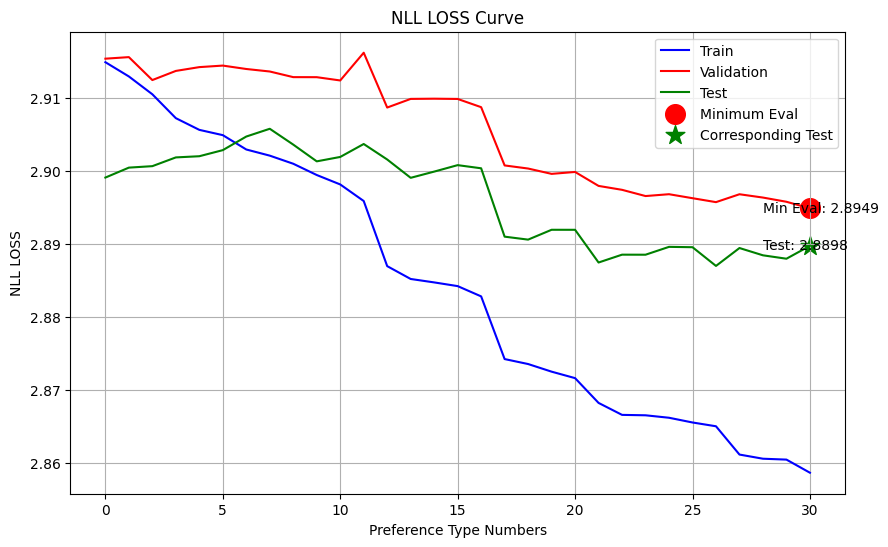

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming eval_list and test_list are already defined

# Find the index of the minimum value in eval_list
min_eval_index = np.argmin(eval_list)

# Get the corresponding value from test_list
corresponding_test_value = test_list[min_eval_index]

plt.figure(figsize=(10, 6))
plt.plot(NLL_LIST, linestyle='-', color='b', label='Train')
plt.plot(eval_list, linestyle='-', color='r', label='Validation')
plt.plot(test_list, linestyle='-', color='g', label='Test')
plt.title('NLL LOSS Curve')
plt.xlabel('Preference Type Numbers')
plt.ylabel('NLL LOSS')
plt.legend()
plt.grid(True)
# plt.show()

# Highlight the points
plt.scatter(min_eval_index, eval_list[min_eval_index], color='red', marker='o', s=200, label='Minimum Eval')
plt.scatter(min_eval_index, corresponding_test_value, color='green', marker='*', s=200, label='Corresponding Test')

# Add text to the figure
plt.text(min_eval_index - 2, eval_list[min_eval_index], f'Min Eval: {eval_list[min_eval_index]:.4f}', ha='left', va='center')
plt.text(min_eval_index - 2, corresponding_test_value, f'Test: {corresponding_test_value:.4f}', ha='left', va='center')


plt.legend()  # Include the legend to show labels for highlighted points
plt.show()

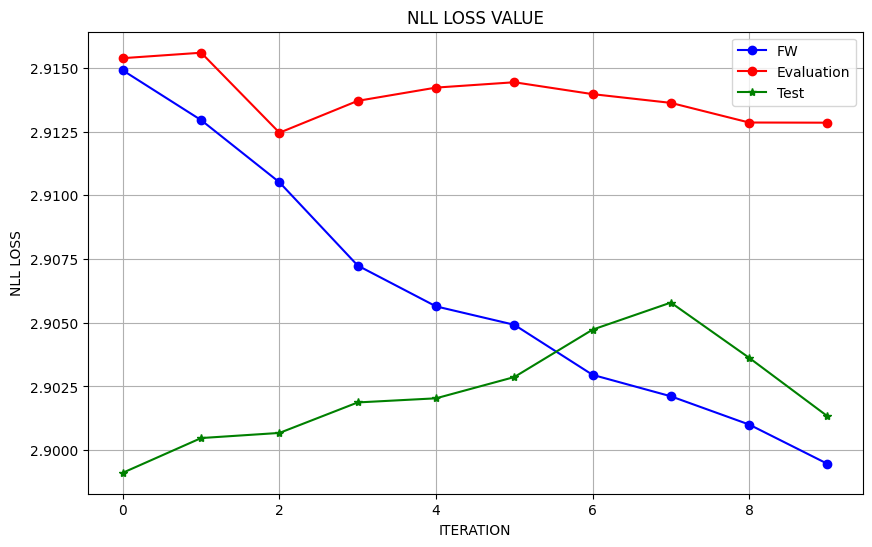

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(NLL_LIST[:10], marker='o', linestyle='-', color='b', label='FW')
plt.plot(eval_list[:10], marker='o', linestyle='-', color='r', label='Evaluation')
plt.plot(test_list[:10], marker='*', linestyle='-', color='g', label='Test')
plt.title('NLL LOSS VALUE')
plt.xlabel('ITERATION')
plt.ylabel('NLL LOSS')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from joblib import dump, load
dump(MNL_problem, 'NN-30type')

['NN-30type']

In [ ]:
NLL_LIST[0], eval_list[0], test_list[0]

(2.914902925491333, 2.91538405418396, 2.8991141319274902)